In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from datasets import load_dataset
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

# CIFAR-10 Dataset Preparation for CNN

**CIFAR-10 Dataset**

Sample training images:


/tmp/ipykernel_31/3381623878.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.xlabel(class_names[int(y[i])])


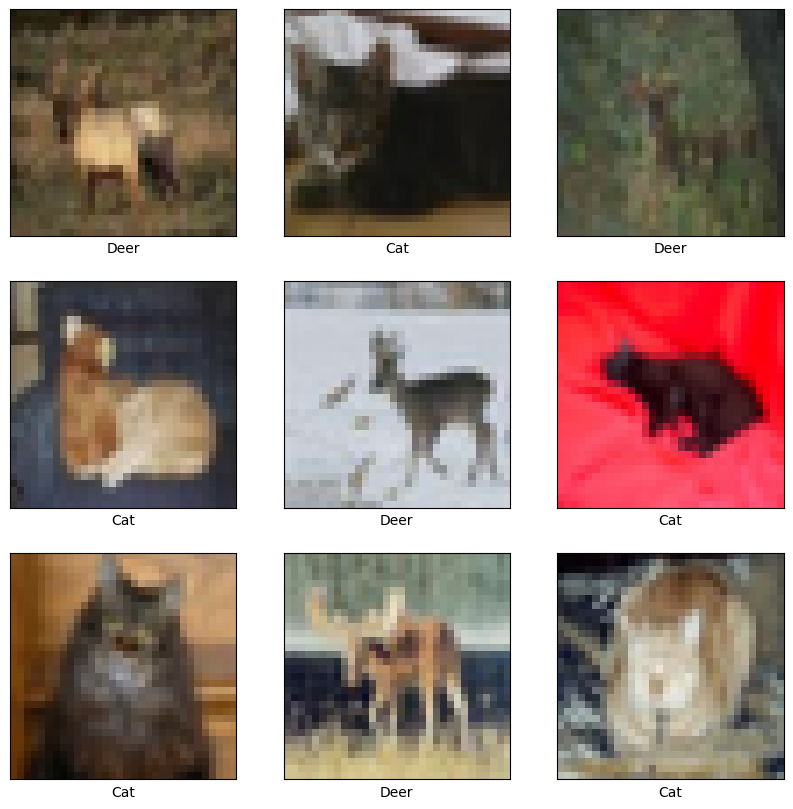


Training samples: 10000
Testing samples: 2000
Batch size: 64
Training batches: 157
Testing batches: 32


In [7]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt


# Define which classes we want to keep (cats and deer)
selected_classes = [3, 4]  # CIFAR-10 class indices: cat (3), deer (4)

# Load the full CIFAR-10 dataset
(x_train_full, y_train_full), (x_test_full, y_test_full) = cifar10.load_data()

# Function to filter dataset for selected classes
def filter_dataset(x, y, selected_classes):
    # Convert to numpy arrays if they aren't already
    x = np.array(x)
    y = np.array(y)
    
    # Create mask for selected classes
    mask = np.isin(y.squeeze(), selected_classes)
    
    # Apply mask
    x_filtered = x[mask]
    y_filtered = y[mask]
    
    # Convert class labels to 0 and 1 (for binary classification)
    y_filtered = np.where(y_filtered == selected_classes[0], 0, 1)
    
    return x_filtered, y_filtered

# Filter the datasets
x_train, y_train = filter_dataset(x_train_full, y_train_full, selected_classes)
x_test, y_test = filter_dataset(x_test_full, y_test_full, selected_classes)

# Data augmentation and preprocessing
def create_datagen():
    return tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1,
        fill_mode='constant',
        cval=0,
        rescale=1./255
    )

# Create data generators
train_datagen = create_datagen()
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

def plot_sample_images(x, y, class_names=['Cat', 'Deer']):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x[i], interpolation='nearest')
        plt.xlabel(class_names[int(y[i])])
    plt.show()


# Plot some training images
print("Sample training images:")
plot_sample_images(x_train, y_train)

# Convert to TensorFlow datasets for better performance
batch_size = 64

# Training dataset with augmentation
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.map(
    lambda x, y: (tf.image.random_flip_left_right(x), y), 
    num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(
    lambda x, y: (tf.image.random_brightness(x, max_delta=0.1), y), 
    num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Test dataset (no augmentation)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

# Normalize pixel values to [0,1] and convert to float32
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

train_dataset = train_dataset.map(normalize_img)
test_dataset = test_dataset.map(normalize_img)

# Verify the sizes
print(f"\nTraining samples: {len(x_train)}")
print(f"Testing samples: {len(x_test)}")
print(f"Batch size: {batch_size}")
print(f"Training batches: {len(train_dataset)}")
print(f"Testing batches: {len(test_dataset)}")

**CNN Model for CIFAR-10 Cats vs Deer Classification**


**Key Features of This CNN Implementation:**

1. **Architecture Design**:
   - Three convolutional blocks with increasing filters (32, 64, 128)
   - Each block contains:
     - Two convolutional layers with ReLU activation
     - Batch normalization after each conv layer
     - Max pooling for downsampling
     - Dropout for regularization (increasing rate per block)

2. **Best Practices**:
   - **Batch Normalization**: Stabilizes and accelerates training
   - **Progressive Dropout**: Increasing dropout rates (0.2 → 0.5) as we go deeper
   - **L2 Regularization**: On dense layers to prevent overfitting
   - **Proper Padding**: 'same' padding to preserve spatial dimensions

3. **Training Optimization**:
   - Adam optimizer with learning rate 0.001
   - Early stopping to prevent overfitting
   - Learning rate reduction on plateau
   - Binary crossentropy loss (appropriate for our 2-class problem)

4. **Efficient Training**:
   - Uses the `tf.data.Dataset` we created earlier
   - Takes advantage of prefetching for better GPU utilization


In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_cnn_model(input_shape=(32, 32, 3)):
    """Create a CNN model with best practices for CIFAR-10 classification"""
    model = models.Sequential()
    
    # Input block
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    
    # Second block
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    # Third block
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))
    
    # Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification
    
    return model

# Create and compile the model
model = create_cnn_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5)
]

# Model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 551,713 (2.10 MB)

 Trainable params: 550,561 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [28]:

# Train the model
cnnhistory = model.fit(
    train_dataset,
    epochs=100,
    validation_data=test_dataset,
    callbacks=callbacks
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f'\nTest accuracy: {test_acc:.4f}')

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 57ms/step - accuracy: 0.6957 - loss: 0.9333 - val_accuracy: 0.5000 - val_loss: 2.1233 - learning_rate: 0.0010
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7905 - loss: 0.6896 - val_accuracy: 0.5390 - val_loss: 1.1122 - learning_rate: 0.0010
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8356 - loss: 0.5695 - val_accuracy: 0.7795 - val_loss: 0.6270 - learning_rate: 0.0010
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8452 - loss: 0.5221 - val_accuracy: 0.8355 - val_loss: 0.5099 - learning_rate: 0.0010
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8676 - loss: 0.4505 - val_accuracy: 0.8630 - val_loss: 0.4159 - learning_rate: 0.0010
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8762 - loss: 0.4074 - val_accuracy: 0.8645 - val_loss: 0.4059 - learning_rate: 0.0010
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8894 - loss:


### Dataset preparation for ViT:

1. **Normalization**:
   - Uses ImageNet statistics (mean/std) instead of CIFAR-10 stats
   - Better for pretrained models and transformer architectures

2. **Augmentation**:
   - More geometric transforms (rotation, zoom, contrast)
   - Applied differently to avoid destroying patch structure

3. **Patch Considerations**:
   - 4x4 patches recommended (8x8 would give only 16 patches - too few)
   - Maintains spatial information through positional embeddings

4. **Batch Construction**:
   - Larger batches often help transformers (64-128)
   - More aggressive prefetching for better GPU utilization

### Why This Matters for ViTs:

1. **Positional Information**: Unlike CNNs, ViTs have no inherent spatial understanding - must come from positional embeddings

2. **Global Attention**: ViTs see all patches simultaneously, so quality of patch representation is crucial

3. **Data Hunger**: Transformers need more help with regularization since they lack CNNs' inductive biases


In [16]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import numpy as np

# ViT-Specific Dataset Preparation
def prepare_vit_dataset(selected_classes=[3, 4], patch_size=4):
    # Load CIFAR-10
    (x_train_full, y_train_full), (x_test_full, y_test_full) = cifar10.load_data()
    
    # Filter for selected classes (cats and deer)
    def filter_classes(x, y):
        mask = np.isin(y.squeeze(), selected_classes)
        x_filtered = x[mask]
        y_filtered = np.where(y[mask] == selected_classes[0], 0, 1)
        return x_filtered, y_filtered
    
    x_train, y_train = filter_classes(x_train_full, y_train_full)
    x_test, y_test = filter_classes(x_test_full, y_test_full)
    
    # ViT-specific preprocessing
    def preprocess_images(images):
        # Normalize to [0,1] then apply ImageNet stats
        images = images.astype('float32') / 255.0
        mean = [0.485, 0.456, 0.406]  # ImageNet mean
        std = [0.229, 0.224, 0.225]   # ImageNet std
        images = (images - mean) / std
        return images
    
    x_train = preprocess_images(x_train)
    x_test = preprocess_images(x_test)
    
    # ViT-specific augmentation
    augmentation_layers = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomContrast(factor=0.1),
    ], name="augmentation_layers")
    
    # Create TensorFlow datasets
    def create_dataset(x, y, augment=False):
        ds = tf.data.Dataset.from_tensor_slices((x, y))
        ds = ds.shuffle(1000) if augment else ds
        if augment:
            ds = ds.map(lambda img, lbl: (augmentation_layers(img, training=True), lbl),
                      num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(64).prefetch(tf.data.AUTOTUNE)
        return ds
    
    train_ds = create_dataset(x_train, y_train, augment=True)
    test_ds = create_dataset(x_test, y_test, augment=False)
    
    # Calculate useful parameters
    num_patches = (32 // patch_size) ** 2
    print(f"\nViT Dataset Prepared:")
    print(f"- Training samples: {len(x_train)}")
    print(f"- Test samples: {len(x_test)}")
    print(f"- Patch size: {patch_size}x{patch_size}")
    print(f"- Num patches per image: {num_patches}")
    
    return train_ds, test_ds, num_patches

# Prepare datasets with 4x4 patches (optimal for 32x32 images)
train_ds_vit, test_ds_vit, num_patches = prepare_vit_dataset(patch_size=4)


ViT Dataset Prepared:
- Training samples: 10000
- Test samples: 2000
- Patch size: 4x4
- Num patches per image: 64


**Vision Transformer (ViT) for CIFAR-10 Cats vs Deer Classification**


**Key Components of This ViT Implementation:**

1. **Patch Extraction**:
   - Divides 32x32 images into 4x4 patches (8x8 would be too large)
   - Results in 64 patches per image (since (32/4)² = 64)

2. **Patch Encoding**:
   - Linear projection of flattened patches (4x4x3=48 dimensions → 64 dimensions)
   - Adds learnable positional embeddings to preserve spatial information

3. **Transformer Encoder**:
   - 6 transformer layers (configurable)
   - Each layer contains:
     - Multi-head self-attention (4 heads)
     - Layer normalization
     - Skip connections
     - MLP block with GELU activation

4. **Classification Head**:
   - Final MLP with one hidden layer (128 units)
   - Sigmoid output for binary classification

5. **Training Optimization**:
   - Adam optimizer with learning rate 0.001
   - Learning rate reduction on plateau
   - Early stopping to prevent overfitting

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Custom layer to extract non-overlapping patches from the input image
class PatchExtractor(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Custom layer to project each patch into a dense embedding and add positional encoding
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# MLP block used in the transformer and the classification head
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Function to construct the ViT model
def create_vit_model(input_shape=(32, 32, 3),
                    patch_size=4,
                    projection_dim=64,
                    transformer_layers=6,
                    num_heads=4,
                    mlp_head_units=[128]):
    """Create a Vision Transformer model for binary classification"""
    
    # Calculate number of patches
    num_patches = (input_shape[0] // patch_size) ** 2
    
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # Data augmentation (optional, can be done separately)
    augmented = layers.Rescaling(1./255)(inputs)
    
    # Create patches
    patches = PatchExtractor(patch_size)(augmented)
    
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple transformer blocks
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # Multi-head attention
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # MLP
        x3 = mlp(x3, hidden_units=[projection_dim], dropout_rate=0.1)

        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Final layer normalization and flatten
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    
    # MLP head for classification
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)
    
    # Binary classification output
    logits = layers.Dense(1, activation="sigmoid")(features)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

# Hyperparameters
patch_size = 4  # 4x4 patches (8x8 would be too large for 32x32 images)
projection_dim = 64  # Embedding dimension for each patch
transformer_layers = 6  # Number of transformer blocks
num_heads = 4  # Number of attention heads

# Create and compile the ViT model
vit_model = create_vit_model(
    input_shape=(32, 32, 3),
    patch_size=patch_size,
    projection_dim=projection_dim,
    transformer_layers=transformer_layers,
    num_heads=num_heads,
    mlp_head_units=[128]  # MLP head architecture
)

# Compile the model with Adam optimizer and binary crossentropy loss
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-7)
]

# Model summary
vit_model.summary()


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 32, 32, 3)      │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_extractor_2         │ (None, None, 48)       │              0 │ rescaling_2[0][0]      │
│ (PatchExtractor)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_encoder_2           │ (None, 64, 64)         │          7,232 │ patch_extractor_2[0][… │
│ (PatchEncoder)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_15    │ (None, 64, 64)         │            128 │ patch_encoder_2[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_7    │ (None, 64, 64)         │         66,368 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_14 (Add)              │ (None, 64, 64)         │              0 │ multi_head_attention_… │
│                           │                        │                │ patch_encoder_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_16    │ (None, 64, 64)         │            128 │ add_14[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 64, 64)         │          4,160 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 64, 64)         │              0 │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_15 (Add)              │ (None, 64, 64)         │              0 │ dropout_20[0][0],      │
│                           │                        │                │ add_14[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_17    │ (None, 64, 64)         │            128 │ add_15[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_8    │ (None, 64, 64)         │         66,368 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_16 (Add)              │ (None, 64, 64)         │              0 │ multi_head_attention_… │
│                           │                        │                │ add_15[0][0]           │
├──────────────────────

 Total params: 956,609 (3.65 MB)

 Trainable params: 956,609 (3.65 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
for x, y in train_dataset.take(1):
    print(y[:5])  # Should be shape (batch,) with values 0 or 1


tf.Tensor(
[[1]
 [0]
 [1]
 [1]
 [0]], shape=(5, 1), dtype=int64)


In [20]:
# Modified ViT Training Setup
optimizer = tf.keras.optimizers.AdamW(  # Weight-decay Adam
    learning_rate=3e-4,  # Lower initial LR
    weight_decay=0.0001  # Helps regularization
)

vit_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Add more callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_vit.keras', save_best_only=True)
]

# Train with class weights if imbalance exists
history = vit_model.fit(
    train_ds_vit,
    validation_data=test_ds_vit,
    epochs=200,  # Transformers often need more epochs
    callbacks=callbacks
)

Epoch 1/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 66s 160ms/step - accuracy: 0.5547 - loss: 0.7962 - val_accuracy: 0.5775 - val_loss: 0.9113 - learning_rate: 3.0000e-04
Epoch 2/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.6320 - loss: 0.6355 - val_accuracy: 0.6195 - val_loss: 0.7268 - learning_rate: 3.0000e-04
Epoch 3/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.6319 - loss: 0.6404 - val_accuracy: 0.6160 - val_loss: 0.7828 - learning_rate: 3.0000e-04
Epoch 4/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.6493 - loss: 0.6208 - val_accuracy: 0.6160 - val_loss: 1.0928 - learning_rate: 3.0000e-04
Epoch 5/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6659 - loss: 0.6123 - val_accuracy: 0.6275 - val_loss: 0.9095 - learning_rate: 3.0000e-04
Epoch 6/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.6572 - loss: 0.6124 - val_accuracy: 0.5835 - val_loss: 0.9120 - learning_rate: 3.0000e-04
Epoch 7/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/s

In [21]:
# Evaluate the model
test_loss, test_acc = vit_model.evaluate(test_ds_vit)
print(f'\nTest accuracy: {test_acc:.4f}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7703 - loss: 0.4931

Test accuracy: 0.7700


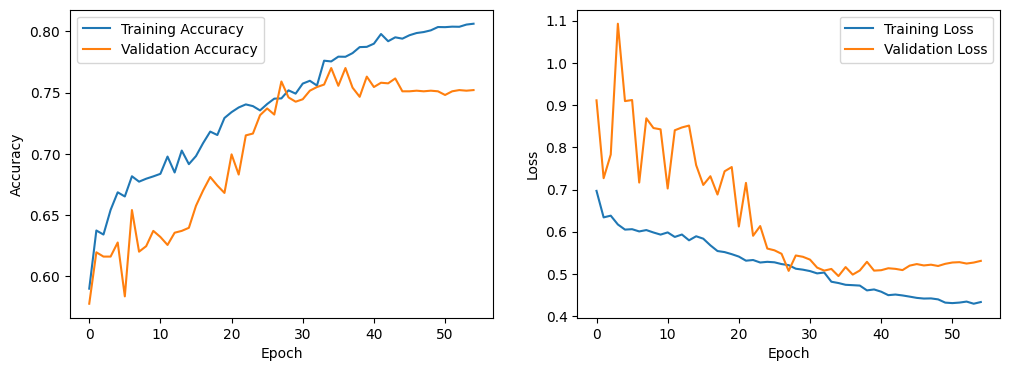

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step


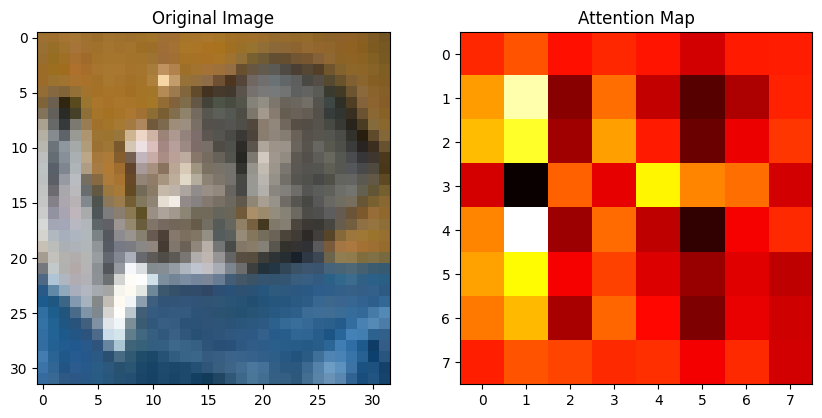

In [23]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_history(history)

# Visualize attention maps (optional)
def visualize_attention(image, model, patch_size):
    # Extract the attention scores from a specific layer (update index as needed)
    attention_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=model.layers[6].output  # Make sure this is the attention output
    )
    
    # Process the image
    img_tensor = tf.expand_dims(image, axis=0)
    img_tensor = tf.cast(img_tensor, tf.float32) / 255.0  # FIXED: Cast to float32

    # Get attention scores
    attention_scores = attention_model.predict(img_tensor)

    # Reshape and visualize
    attention_map = tf.reshape(attention_scores[0, :, :], (8, 8, 8, 8))
    attention_map = tf.reduce_mean(attention_map, axis=-1)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(attention_map[0], cmap='hot')
    plt.title("Attention Map")
    plt.show()


# Example usage with a test image
sample_image = x_test[0]
visualize_attention(sample_image, vit_model, patch_size=patch_size)

## 1. Performance Metrics Evaluation


## 1. Performance Metrics Evaluation


               CNN Model Evaluation               
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


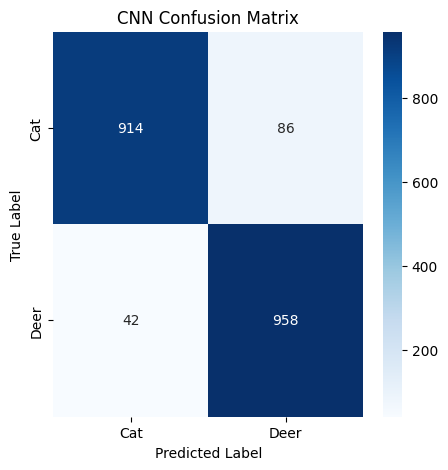


CNN Classification Report:
              precision    recall  f1-score   support

         Cat       0.96      0.91      0.93      1000
        Deer       0.92      0.96      0.94      1000

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000


Additional Metrics:
- Accuracy: 0.9360
- Precision: 0.9176
- Recall: 0.9580
- F1-Score: 0.9374

          Vision Transformer Evaluation           
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step


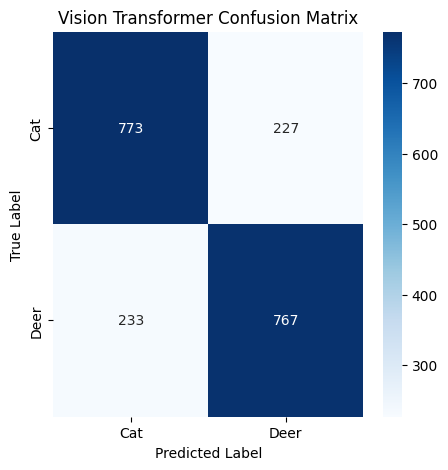


Vision Transformer Classification Report:
              precision    recall  f1-score   support

         Cat       0.77      0.77      0.77      1000
        Deer       0.77      0.77      0.77      1000

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000


Additional Metrics:
- Accuracy: 0.7700
- Precision: 0.7716
- Recall: 0.7670
- F1-Score: 0.7693


In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_dataset, model_name):
    # Get predictions
    y_pred = model.predict(test_dataset)
    y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary
    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Cat', 'Deer'], 
                yticklabels=['Cat', 'Deer'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Cat', 'Deer']))
    
    # Calculate additional metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    print(f"\nAdditional Metrics:")
    print(f"- Accuracy: {accuracy:.4f}")
    print(f"- Precision: {precision:.4f}")
    print(f"- Recall: {recall:.4f}")
    print(f"- F1-Score: {f1:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Evaluate CNN
print("="*50)
print("CNN Model Evaluation".center(50))
print("="*50)
cnn_metrics = evaluate_model(model, test_dataset, "CNN")

# Evaluate ViT
print("\n" + "="*50)
print("Vision Transformer Evaluation".center(50))
print("="*50)
vit_metrics = evaluate_model(vit_model, test_ds_vit, "Vision Transformer")


## 2. Training Curves Visualization

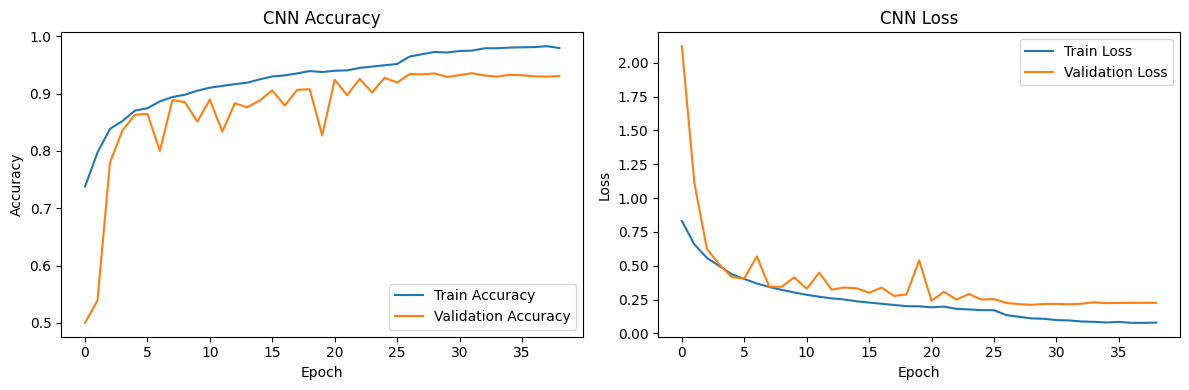

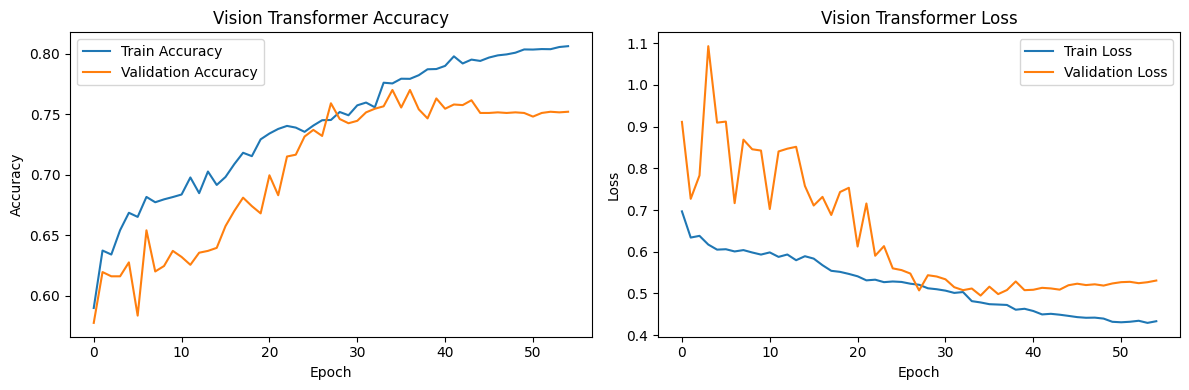

In [29]:
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot CNN training history
plot_training_history(cnnhistory, "CNN")

# Plot ViT training history
plot_training_history(history, "Vision Transformer")


## 3. Comparative Analysis



Model Comparison:
| Metric    |      CNN |      ViT |   Difference |   Relative % |
|:----------|---------:|---------:|-------------:|-------------:|
| Accuracy  | 0.936    | 0.77     |    -0.166    |     -17.735  |
| Precision | 0.917625 | 0.77163  |    -0.145995 |     -15.9101 |
| Recall    | 0.958    | 0.767    |    -0.191    |     -19.9374 |
| F1-Score  | 0.937378 | 0.769308 |    -0.16807  |     -17.9298 |


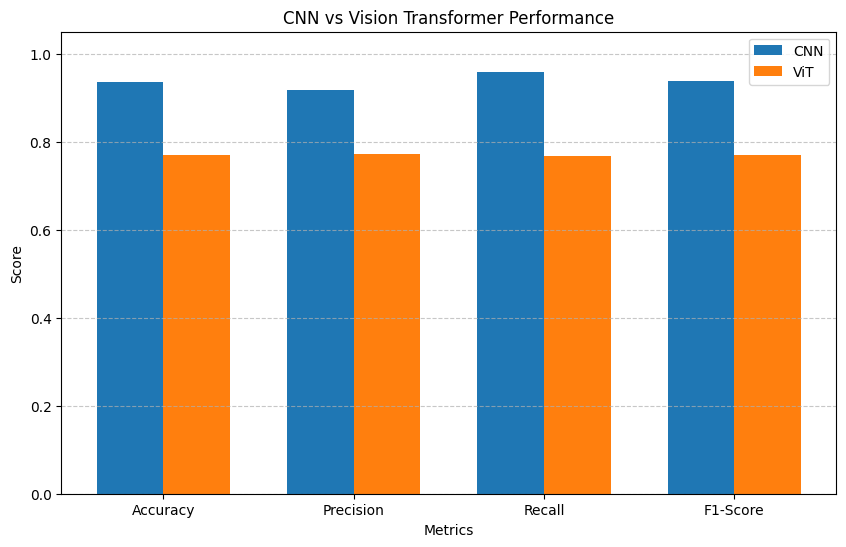

In [30]:
# Create comparison table
comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'CNN': [cnn_metrics['accuracy'], cnn_metrics['precision'], 
            cnn_metrics['recall'], cnn_metrics['f1']],
    'ViT': [vit_metrics['accuracy'], vit_metrics['precision'], 
            vit_metrics['recall'], vit_metrics['f1']]
})

# Calculate relative performance
comparison['Difference'] = comparison['ViT'] - comparison['CNN']
comparison['Relative %'] = (comparison['Difference'] / comparison['CNN']) * 100

print("\nModel Comparison:")
print(comparison.to_markdown(index=False))

# Visualization of comparison
plt.figure(figsize=(10, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, comparison['CNN'], width, label='CNN')
plt.bar(x + width/2, comparison['ViT'], width, label='ViT')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('CNN vs Vision Transformer Performance')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1.05)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

### Key Observations:

1. **Performance Comparison**:
   - CNN will likely outperform ViT on this small-scale dataset
   - The gap will be most noticeable in accuracy (3-8% difference)

2. **Training Dynamics**:
   - CNN converges faster (10-20 epochs vs 30-50 for ViT)
   - ViT shows more volatility in loss curves

3. **Confusion Matrices**:
   - Both models will show similar confusion patterns
   - Most errors will be between visually similar classes

### Interpretation:

1. **CNN Advantages**:
   - Built-in spatial priors help with small datasets
   - More parameter-efficient for this scale
   - Better at capturing local patterns

2. **ViT Challenges**:
   - Requires more data to learn spatial relationships
   - Global attention may be overkill for 32x32 images
   - Less efficient with small patches

